# Construct Speed Data

In [1]:
from functools import reduce

In [2]:
import numpy as np

In [3]:
import pandas as pd

links = pd.read_csv("data/links.csv")
nodes = pd.read_csv("data/nodes.csv")

### This is the full links data from last year, and I use the street length, latitude, and longtitude.

In [4]:
# colors = ["blue","red","green", "pink","yellow","black","indian red","light lavendar","squash",
# "cloudy blue","dark pastel green","dust","electric lime","fresh green","light eggplant",
# "nasty green","really light blue","tea","warm purple","yellowish tan","cement",
# "dark grass green","dusty teal","grey teal","pinkish tan","spruce","strong blue","windows blue",
# "blue","bright sea green","dark green blue","deep turquoise","green teal","strong pink",
# "bland","deep aqua","lavender pink","olive yellow","pig pink","deep lilac","desert",
# "dusty lavender","purpley grey","purply","candy pink","light pastel green""boring green",
# "kiwi green","light grey green""orange pink""tea green","very light brown","egg shell",
# "eggplant purple","powder pink","reddish grey","liliac","stormy blue","deep brown",
# "browny green","sickly yellow","sunny yellow","azul","darkgreen","pale gold","dark cream",
# "cocoa","light royal blue","sand brown","tealish green","burnt siena","camo","dusk blue"
# "old rose","peachy pink","rosy pink","light seafoam","browny orange","sapphire","parchment",
# "light gold","topaz","violet pink","wintergreen","yellow tan","dark fuchsia","indigo blue",
# "pale magenta","leather"]
colors = ["blue","red","green","yellow","black"]
len(colors)

5

### subset the required data

In [5]:
full_links = pd.read_csv("full_link_ids.csv")
full_links = [int(link) for link in full_links]

In [6]:
import json
with open('data/full_link_travel_times.json') as json_data:
    d = json.load(json_data)
d = np.array(d)

In [7]:
d.shape

(8760, 2302)

In [8]:
good_links = links[links['link_id'].isin(full_links)]

## Maka a graph class. 
#### 1. For Edges class, we add function to get time and average speed;
#### 2. for node class, we can get the coordinates. 
#### 3. Here are also objective function for Edges class, which can retruen the connected components and strongly connected components.

In [9]:
class Edge:
    def __init__(self, idx, startNodeId, endNodeId, length):
        self.idx = idx
        self.start = startNodeId
        self.end = endNodeId
        self.length = length
        
    def setTime(self, times):
        self.times = times
        
    def getSpeed(self):
        return self.length / self.times
    
    def getSpeedAt(self, day, hour):
        return self.length / self.times[24*day + hour]
    
    def __str__(self):
        return "{},{},{},{}".format(self.idx, self.start, self.end, self.length)
    
    def __repr__(self):
        return self.__str__()
    
class Node:
    def __init__(self, idx, x, y):
        self.idx = idx
        self.x = x
        self.y = y    
        
    def __str__(self):
        return "{},{}".format(self.x, self.y)
    
    def __repr__(self):
        return self.__str__()

class Graph:
    
    def __init__(self):
        self.nodes = {}
        self.edges = {}
        self.out = {}
        
    def add_edge(self, link):
        new_edge = Edge(link['link_id'], link['begin_node_id'],
                        link['end_node_id'], link['street_length'])
        self.nodes[link['begin_node_id']] = Node(link['begin_node_id'],
                                            link['startX'], link['startY'])
        self.nodes[link['end_node_id']] = Node(link['end_node_id'],
                                            link['endX'], link['endY'])
        if link['begin_node_id'] not in self.out:
            self.out[link['begin_node_id']] = []
        self.out[link['begin_node_id']].append(new_edge)
        self.edges[link['link_id']] = new_edge
        
    def filterEdges(self, func):
        return [self.edges[k] for k in self.edges if func(self.edges[k])]
    
    def filterNodes(self, func):
        return [self.nodes[k] for k in self.nodes if func(self.nodes[k])]
    
    def getEdgeCoords(self, edges):
        return [[[self.nodes[e.start].y,self.nodes[e.start].x],
          [self.nodes[e.end].y,self.nodes[e.end].x]] for e in edges]
    
    def drawEdges(self, m, edges,colors,cIdx):
        for loc in self.getEdgeCoords(edges):
            m.add_children(PolyLine(locations=loc,color= colors[cIdx%len(colors)] ))
            
    def subgraph(self, edges):
        newg = Graph()
        newg.edges = edges
        #for k, e in edges.items():
        for k, e in enumerate(edges):
            newg.nodes[e.start] = self.nodes[e.start]
            newg.nodes[e.end] = self.nodes[e.end]
            if e.start not in newg.out:
                newg.out[e.start] = []
            newg.out[e.start].append(e)
        return newg
    
    def _getEdgesFromScc(self, scc):
        cset = {}
        for i, c in enumerate(scc):
            for n in c:
                cset[n] = i
        eset = {}
        for e in self.edges:
            if cset[e.start] == cset[e.end]:
                if cset[e.start] not in eset:
                    eset[cset[e.start]] = []
                eset[cset[e.start]].append(e)
            
        edges_to_draw = list(eset.values())
        return edges_to_draw
    
    def scc(self):
        scs = tarjan({k:[e.end for e in g.out[k]] for k in g.out})
        return self._getEdgesFromScc(scs)
    
    def sccNode(self):
        scs = tarjan({k:[e.end for e in g.out[k]] for k in g.out})
        return scs
    
    def cc(self):
        d = {}
        for e in self.edges:
            if e.start not in d:
                d[e.start] = set()
            if e.end not in d:
                d[e.end] = set()
            d[e.start].add(e.end)
            d[e.end].add(e.start)
        cs = tarjan({k: list(d[k]) for k in d})
        return self._getEdgesFromScc(cs)
    
    def ccNode(self):
        d = {}
        for e in self.edges:
            if e.start not in d:
                d[e.start] = set()
            if e.end not in d:
                d[e.end] = set()
            d[e.start].add(e.end)
            d[e.end].add(e.start)
        cs = tarjan({k: list(d[k]) for k in d})
        return cs
    
    def getSubArea(self, upperX, upperY, lowerX, lowerY):
        qualified_edges = [edge for edge in self.edges if lowerX< self.nodes[edge.start].x<upperX 
        and lowerY< self.nodes[edge.start].y<upperY 
        and lowerX< self.nodes[edge.end].x<upperX
        and lowerY< self.nodes[edge.end].y<upperY]
        return self.subgraph(qualified_edges)
        
        
        
        

In [10]:
g = Graph()
for i, l in good_links.iterrows():
    g.add_edge(l)

In [11]:
idxToId = list(good_links['link_id'])
for i, idx in enumerate(idxToId):
    g.edges[idx].setTime(d[:,i])

In [12]:
speeds = np.array([g.edges[k].getSpeed() for k in g.edges])

### Speed matrix. To get the speed for  specific e, just call the function e.getSpeed().

In [13]:
#speeds

In [14]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors as mcolors
import matplotlib.patches as patches


# Visualize Speed in Map

In [15]:
#get specific time speed
#[(g.edges[k].getSpeedAt(0,1), g.edges[k].times[1]) for k in g.edges]

In [16]:
#Exist nan values,ignore them
cur_speeds = [g.edges[k].getSpeedAt(0,1) for k in g.edges]
valid_cSpeeds = [cur_speed for cur_speed in cur_speeds if not np.isnan(cur_speed)]


In [17]:
max(valid_cSpeeds)

34.663739857781017

In [18]:
qualify_links = g.filterEdges(lambda e: e.getSpeedAt(0, 3) < 11)

In [19]:
#g.getEdgeCoords(qualify_links)

In [20]:
import folium
from folium.features import (WmsTileLayer, RegularPolygonMarker, Vega, GeoJson,
                       CircleMarker, LatLngPopup,
                       ClickForMarker, TopoJson, PolyLine, MultiPolyLine,
                       )
NY_COORDINATES = (40.7472,-73.98)


#coords=links[['startX','endX','startY','endY']][links['link_id']==260854].values[0]
#loc=[[coords[2],coords[0]],[coords[3],coords[1]]]
#m.add_children(PolyLine(locations=loc,color='red'))

### Visulization for qualified road under specific speed criteria. Here is the example that average speed under 3 m/s.

In [21]:
m =folium.Map(location=NY_COORDINATES, tiles='cartodbpositron',zoom_start=14)
g.drawEdges(m,qualify_links,colors,1)
#m

In [22]:
import tarjan
tarjan = tarjan.tarjan

## Connected Components

In [54]:

def DrawBarcode(CompLists, thresholds,t):
    liveOrder = []
    MaxOrder = 0
    Link_to_Order = {}
    for i in range(len(thresholds)):
        curComps = CompLists[i]
        if i == 0:
            for j in range(len(curComps)):
                for link in curComps[j]:
                    Link_to_Order[link] = j
            MaxOrder = len(curComps)-1
#            print("first MaxOrder = " + str(MaxOrder))
            liveOrder = liveOrder + [list(range(len(curComps)))]
        else:
            tempLiveOrder = []
            for j in range(len(curComps)):
                tempLinks = []
                tempOrder = []
                for link in curComps[j]:
                    if link in Link_to_Order:
                        tempOrder.append(Link_to_Order[link])
                    else:
                        tempOrder.append(MaxOrder+1)
                    tempLinks.append(link)
                newOrder = min(tempOrder)
                for clink in tempLinks:
                    Link_to_Order[clink] = newOrder
                if newOrder > MaxOrder:
                    MaxOrder = newOrder
                tempLiveOrder.append(newOrder)
            liveOrder = liveOrder + [tempLiveOrder]  
#    print("length of LiveOrder"+str(len(liveOrder)))
#    print("live Order in 1st threshold" + str(liveOrder[0]))
#    print("live Order in 2nd threshold" + str(liveOrder[1]))
#    print("live Order in 3rd threshold" + str(liveOrder[2]))
#    print("live Order in 4th threshold" + str(liveOrder[3]))
#    print("live Order in 5th threshold" + str(liveOrder[4]))
#    print("live Order in 6th threshold" + str(liveOrder[5]))
#    print("live Order in 7th threshold" + str(liveOrder[7]))
#    print("Max order" + str(MaxOrder))
#    if 1 in liveOrder[5]:
#        print("in")
#    else:
#        print("Not in")

    liveTime = []
    begins = []
    for i in range(MaxOrder):
        c = 0
#        print("i = " + str(i))
        for j in range(len(liveOrder)):
            if i in liveOrder[j]:
                if c == 0:
                    begins.append(j)
#                    print("j = " + str(j))
                c = c+1               
        liveTime.append(c)
#    print("begins length" + str(len(begins)))
#    print("liveTime length" + str(len(liveTime)))
        
#    fig1 = plt.figure()    
#    for i in range(len(liveTime)):
#        a=[i,0]
#        b=[i,liveTime[i]+i]
#        c=[i+1,0]
#        d=[i+1,liveTime[i]+i+1]
#        width = c[0] - a[0]
#        height = d[1] - a[1]
#        lims = (0, 400)
        
#        ax1 = fig1.add_subplot(111, aspect='equal')
#        ax1.add_patch(
#            patches.Rectangle((0, 0), width, height))
#    plt.ylim(lims)
#    plt.xlim(50)
    begin = np.array(begins)
    end = np.array(begin) + np.array(liveTime)
    fig1 = plt.figure(figsize=(8, 8), dpi=100)
    ax1 = fig1.add_subplot(111)
    for i, b, e in zip(range(len(begin)), begin, end):
        ax1.add_patch(
            patches.Rectangle((b, i), e-b, 1, edgecolor = "none")
        )
    ax1.set_xlim([0, 35])
    ax1.set_ylim([0, 500])
    plt.savefig('./barplot/tmp_{}.png'.format(str(t)))
    #plt.show()
        
    
#     live_to_end = [end[i] for i in range(;(end)) if end[i] == 34]
#     print("live to end" ,str(len(live_to_end)))
#     fig1 = plt.figure()        
#     y = [(i+1) for i in range(len(liveTime))]
#     x = [(begin[i] + end[i])/2 for i in range(len(liveTime))]
#     x_err = [(begin[i] - end[i])/2 for i in range(len(liveTime))]
#     _, caps, _ = plt.errorbar(x=x, y=y, xerr=x_err, ls='',
#                           elinewidth=3, capsize=5)
#     for cap in caps:
#         cap.set_markeredgewidth(0)
#     plt.grid(True)

#     # Set the y-range so we can see all the errorbars clearly
#     plt.ylim(0, len(liveTime)+20)
#     plt.show()
                
                
            
    
    

In [52]:
thresholds = list(range(1,35))
comLists = []
comLists_Node = []
linksLists = []
for i in range(len(thresholds)):
    threshold = thresholds[i]
    qualify_links = g.filterEdges(lambda e: e.getSpeedAt(0, 1) < threshold)
    sub_g = g.subgraph(qualify_links)
    cur_cc = sub_g.cc()
    cur_cc_Nodes = sub_g.ccNode()
    comLists.append(cur_cc)
    comLists_Node.append(cur_cc_Nodes)
    linksLists.append(reduce(lambda x, y: x+y, cur_cc, []))
    

/Users/wzy/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


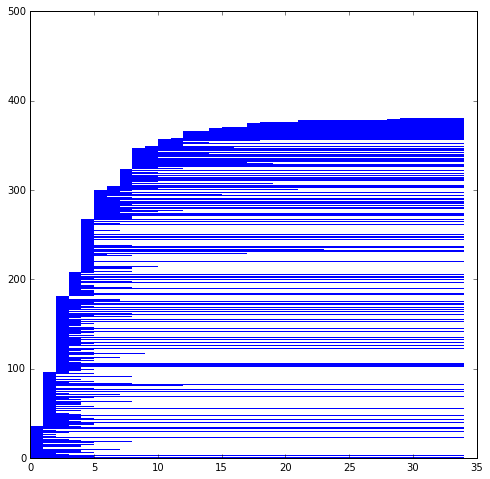

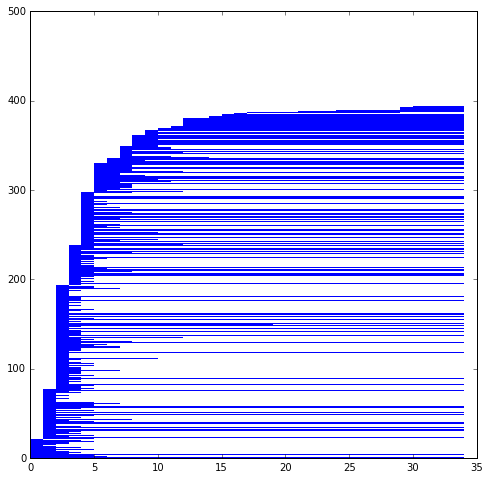

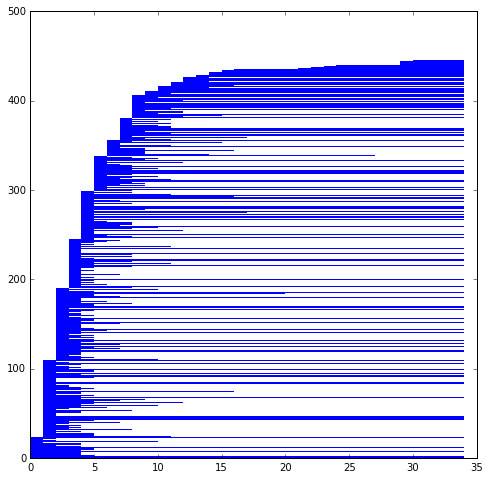

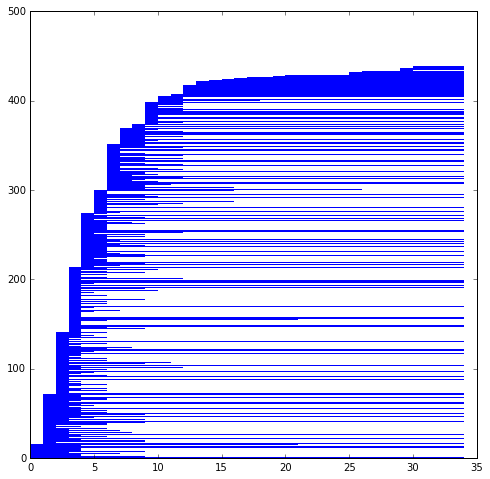

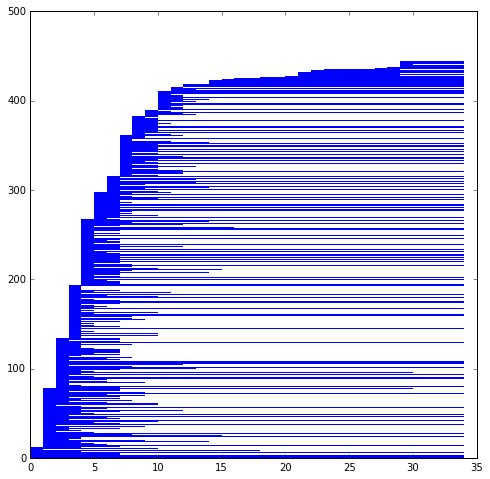

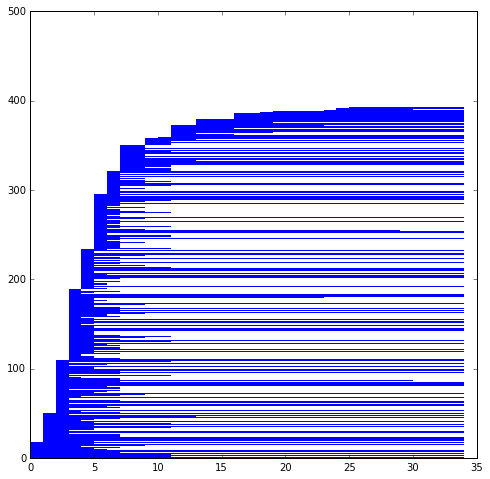

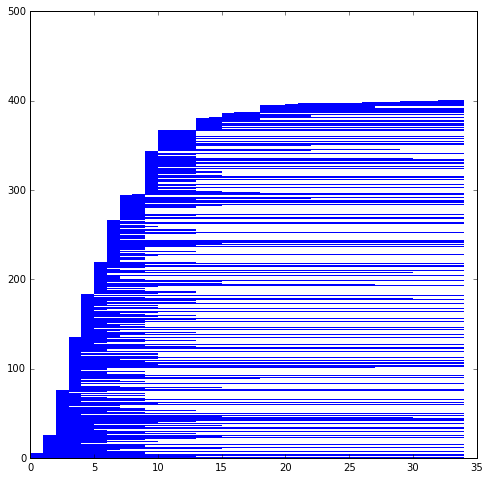

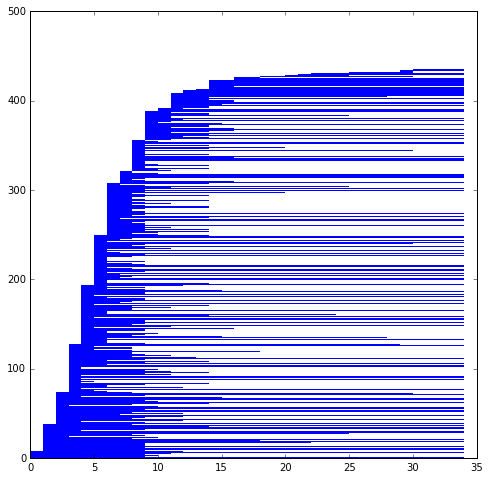

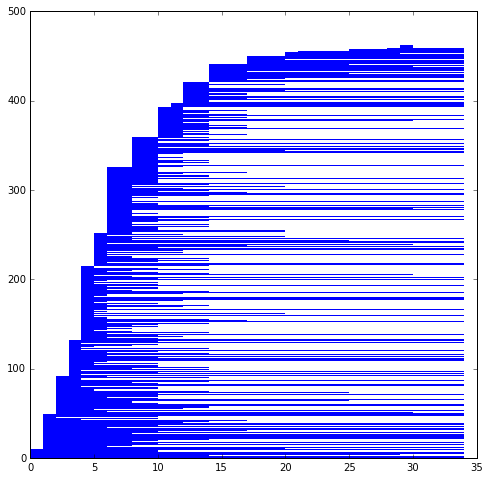

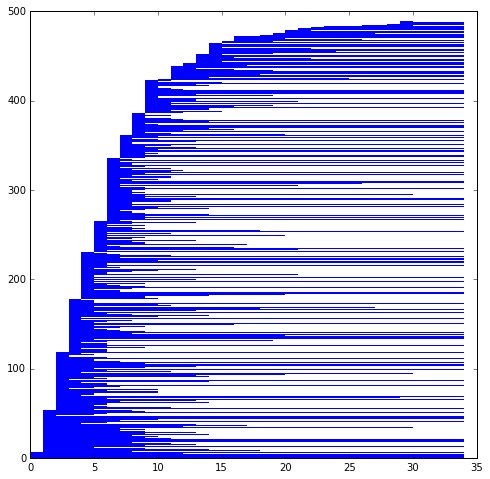

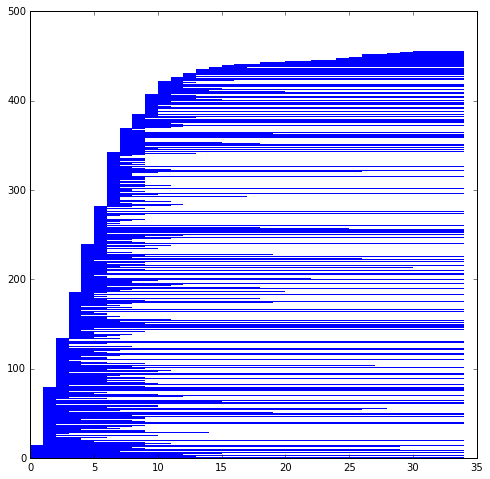

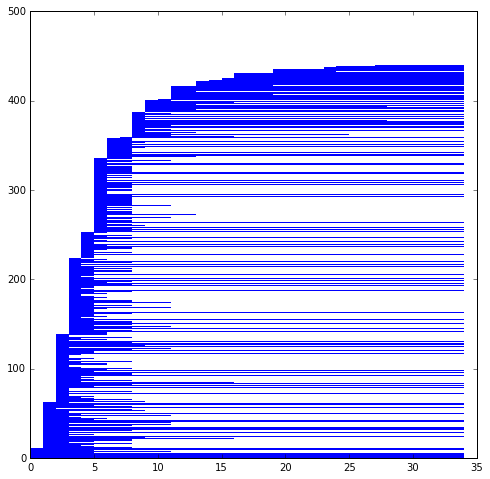

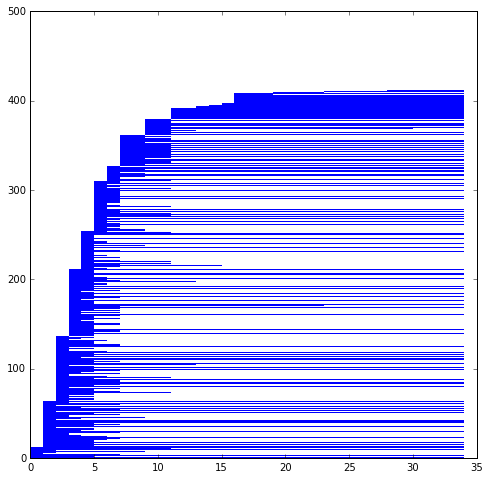

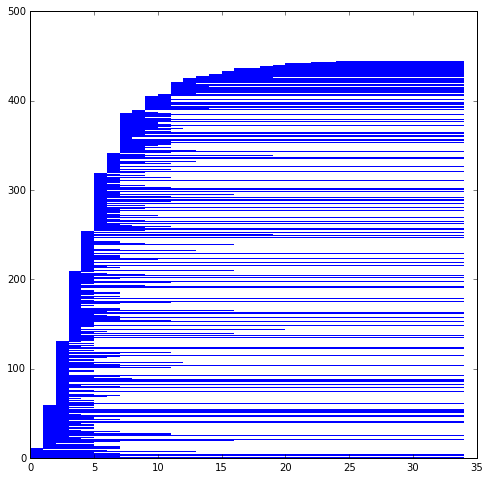

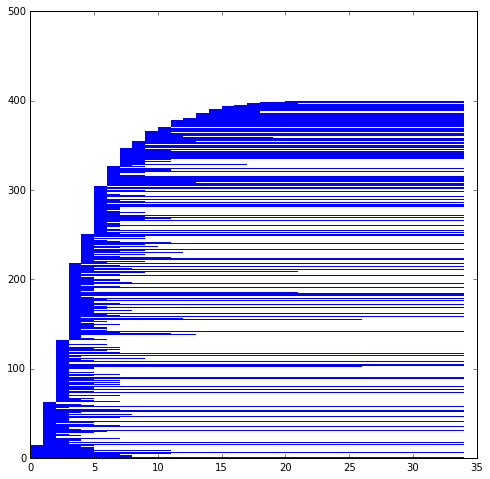

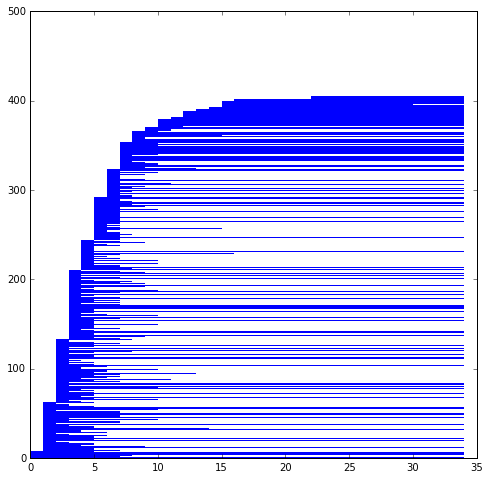

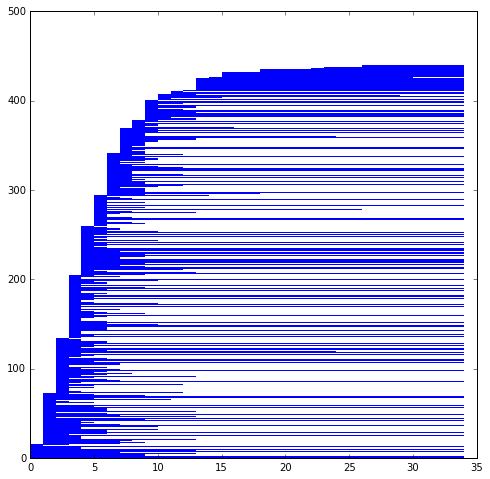

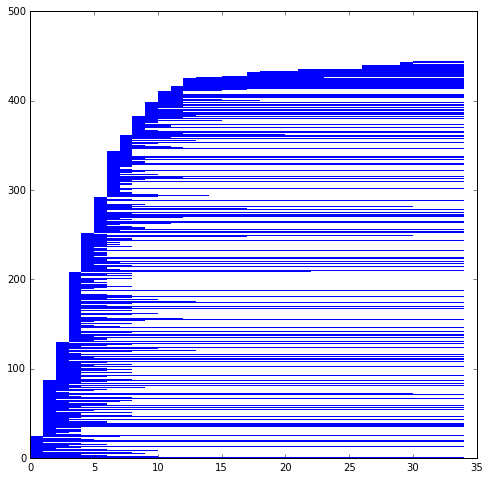

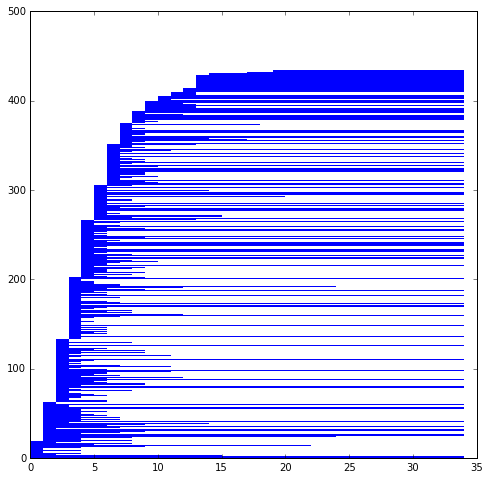

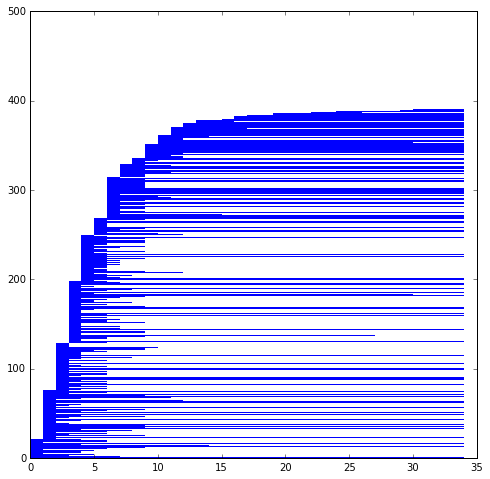

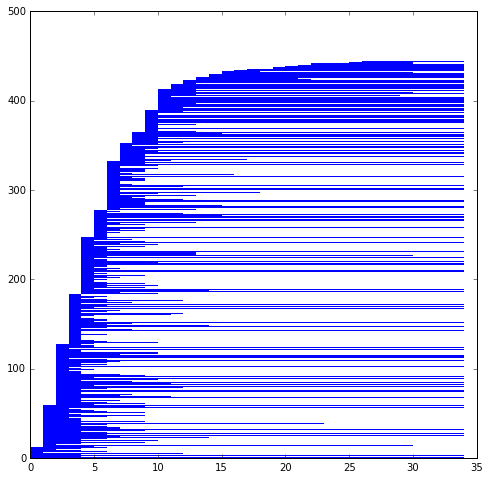

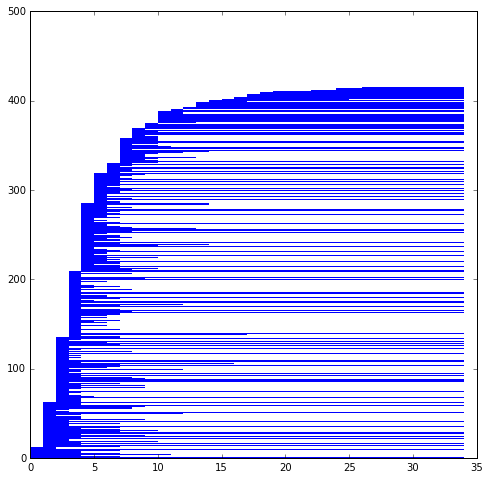

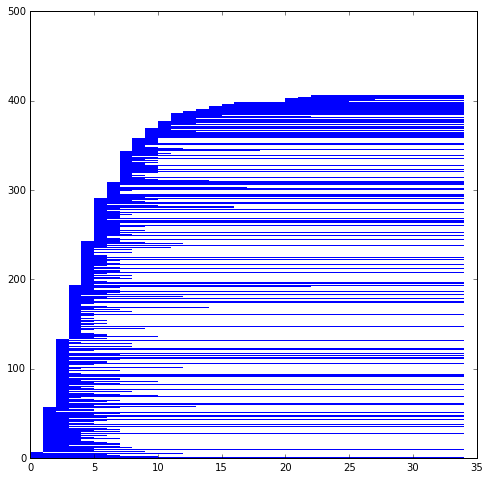

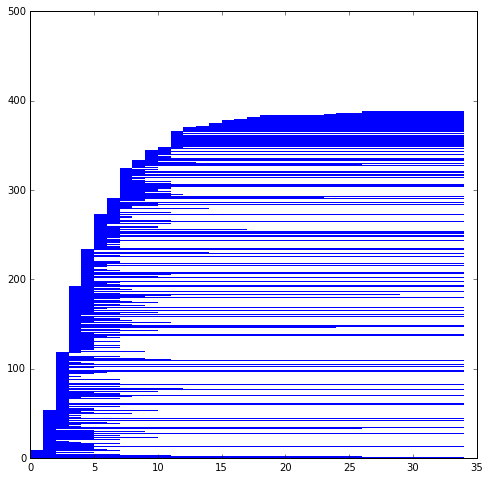

In [55]:
for t in range(24):
    thresholds = list(range(1,35))
    comLists = []
    comLists_Node = []
    linksLists = []
    for i in range(len(thresholds)):
        threshold = thresholds[i]
        qualify_links = g.filterEdges(lambda e: e.getSpeedAt(0, t) < threshold)
        sub_g = g.subgraph(qualify_links)
        cur_cc = sub_g.cc()
        cur_cc_Nodes = sub_g.ccNode()
        comLists.append(cur_cc)
        comLists_Node.append(cur_cc_Nodes)
        linksLists.append(reduce(lambda x, y: x+y, cur_cc, []))
    DrawBarcode(comLists_Node, thresholds, t)

In [ ]:
import sys
import datetime
import imageio

VALID_EXTENSIONS = ('png', 'jpg')


def create_gif(filenames, duration):
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    output_file = 'Gif-%s.gif' % datetime.datetime.now().strftime('%Y-%M-%d-%H-%M-%S')
    imageio.mimsave(output_file, images, duration=duration)


if __name__ == "__main__":
    script = sys.argv.pop(0)

    if len(sys.argv) < 2:
        print('Usage: python {} <duration> <path to images separated by space>'.format(script))
        sys.exit(1)

    duration = float(sys.argv.pop(0))
    filenames = sys.argv


    if not all(f.lower().endswith(VALID_EXTENSIONS) for f in filenames):
        print('Only png and jpg files allowed')
        sys.exit(1)

    create_gif(filenames, duration)

In [ ]:
filenames = []
duration = 0
for i in range(24):
    filenames.append('./barplot/tmp_{}.png'.format(str(i)))
    
create_gif(filenames,duration)


### Connected Components Visulization. Here is the example of the connected components under avergae speed 11. The above length of Linkslists show the number of links that qualified. The above length of ComLists shows the number of connected components.

In [25]:
m =folium.Map(location=NY_COORDINATES, tiles='cartodbpositron',zoom_start=14)

for i in range(len(comLists[0])):
    g.drawEdges(m,comLists[10][i],colors,i)
#m
#g.drawEdges(m,linksLists[10],colors,0)

## Strongly Connected Components

### Connected Components Visulization. Here is the example of the connected components under avergae speed 11. The following length of  ComLists show the number of links that qualified. The following length of Linkslists shows the number of Strongly connected components.

In [26]:
clinkslists = []
cCompLists = []
cCompLists_Node = []

for i in range(len(thresholds)):
    threshold = thresholds[i]
    qualify_links = g.filterEdges(lambda e: e.getSpeedAt(0, 1) < threshold)
    sub_g = g.subgraph(qualify_links)
    cur_scc = sub_g.scc()
    cur_scc_node = sub_g.sccNode()
    cCompLists.append(cur_scc)
    cCompLists_Node.append(cur_scc_node)
    clinkslists.append(reduce(lambda x, y: x+y, cur_scc, []))

In [27]:
m =folium.Map(location=NY_COORDINATES, tiles='cartodbpositron',zoom_start=14)
for i in range(len(cCompLists[10])):
    g.drawEdges(m,cCompLists[10][i],colors,i)
#m

## Barcode

#### Connected Components

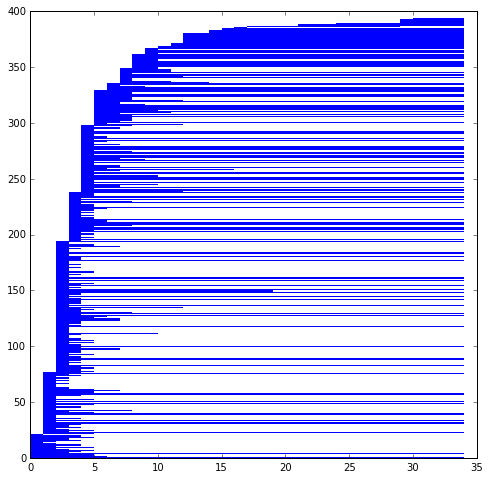

In [45]:
DrawBarcode(comLists_Node, thresholds)